In [50]:
import tensorflow as tf 
from tensorflow import keras    
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2 as cv

In [51]:
x=np.load('../BraiNeoCare/Datasets/GAT/zenodo_data_consensus_GAT.npy', mmap_mode='r')
y=np.load('../BraiNeoCare/Datasets/GAT/zenodo_labels_consensus_GAT.npy', mmap_mode='r')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [52]:
model = keras.models.load_model("../BraiNeoCare/GAT_model_1/cp_0198.ckpt/")
model.layers[-1].activation = None

In [53]:
mean=np.load("mean.npy")
std=np.load("std.npy")

def PreprocesSignal(signal):
    signal=(signal-mean)/std
    signal=np.expand_dims(signal,axis=-1)
    signal=np.expand_dims(signal,axis=0)
    return signal

def GradCAM(signal,model):
    
    grad_model = keras.Model(model.inputs,[model.get_layer("gat_layer_5").output,model.output])

    with tf.GradientTape() as tape:
        GAT_outputs, predictions = grad_model(signal)
        Class=predictions[:,0]

    grads = tape.gradient(Class, GAT_outputs)
    GAT_outputs = GAT_outputs[0]
    
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    heatmap = GAT_outputs * pooled_grads

    heatmap = tf.squeeze(heatmap)
    maximum=tf.reduce_max(heatmap)
    heatmap = tf.nn.relu(heatmap)/maximum

    return heatmap.numpy()

1.0
0.99107766


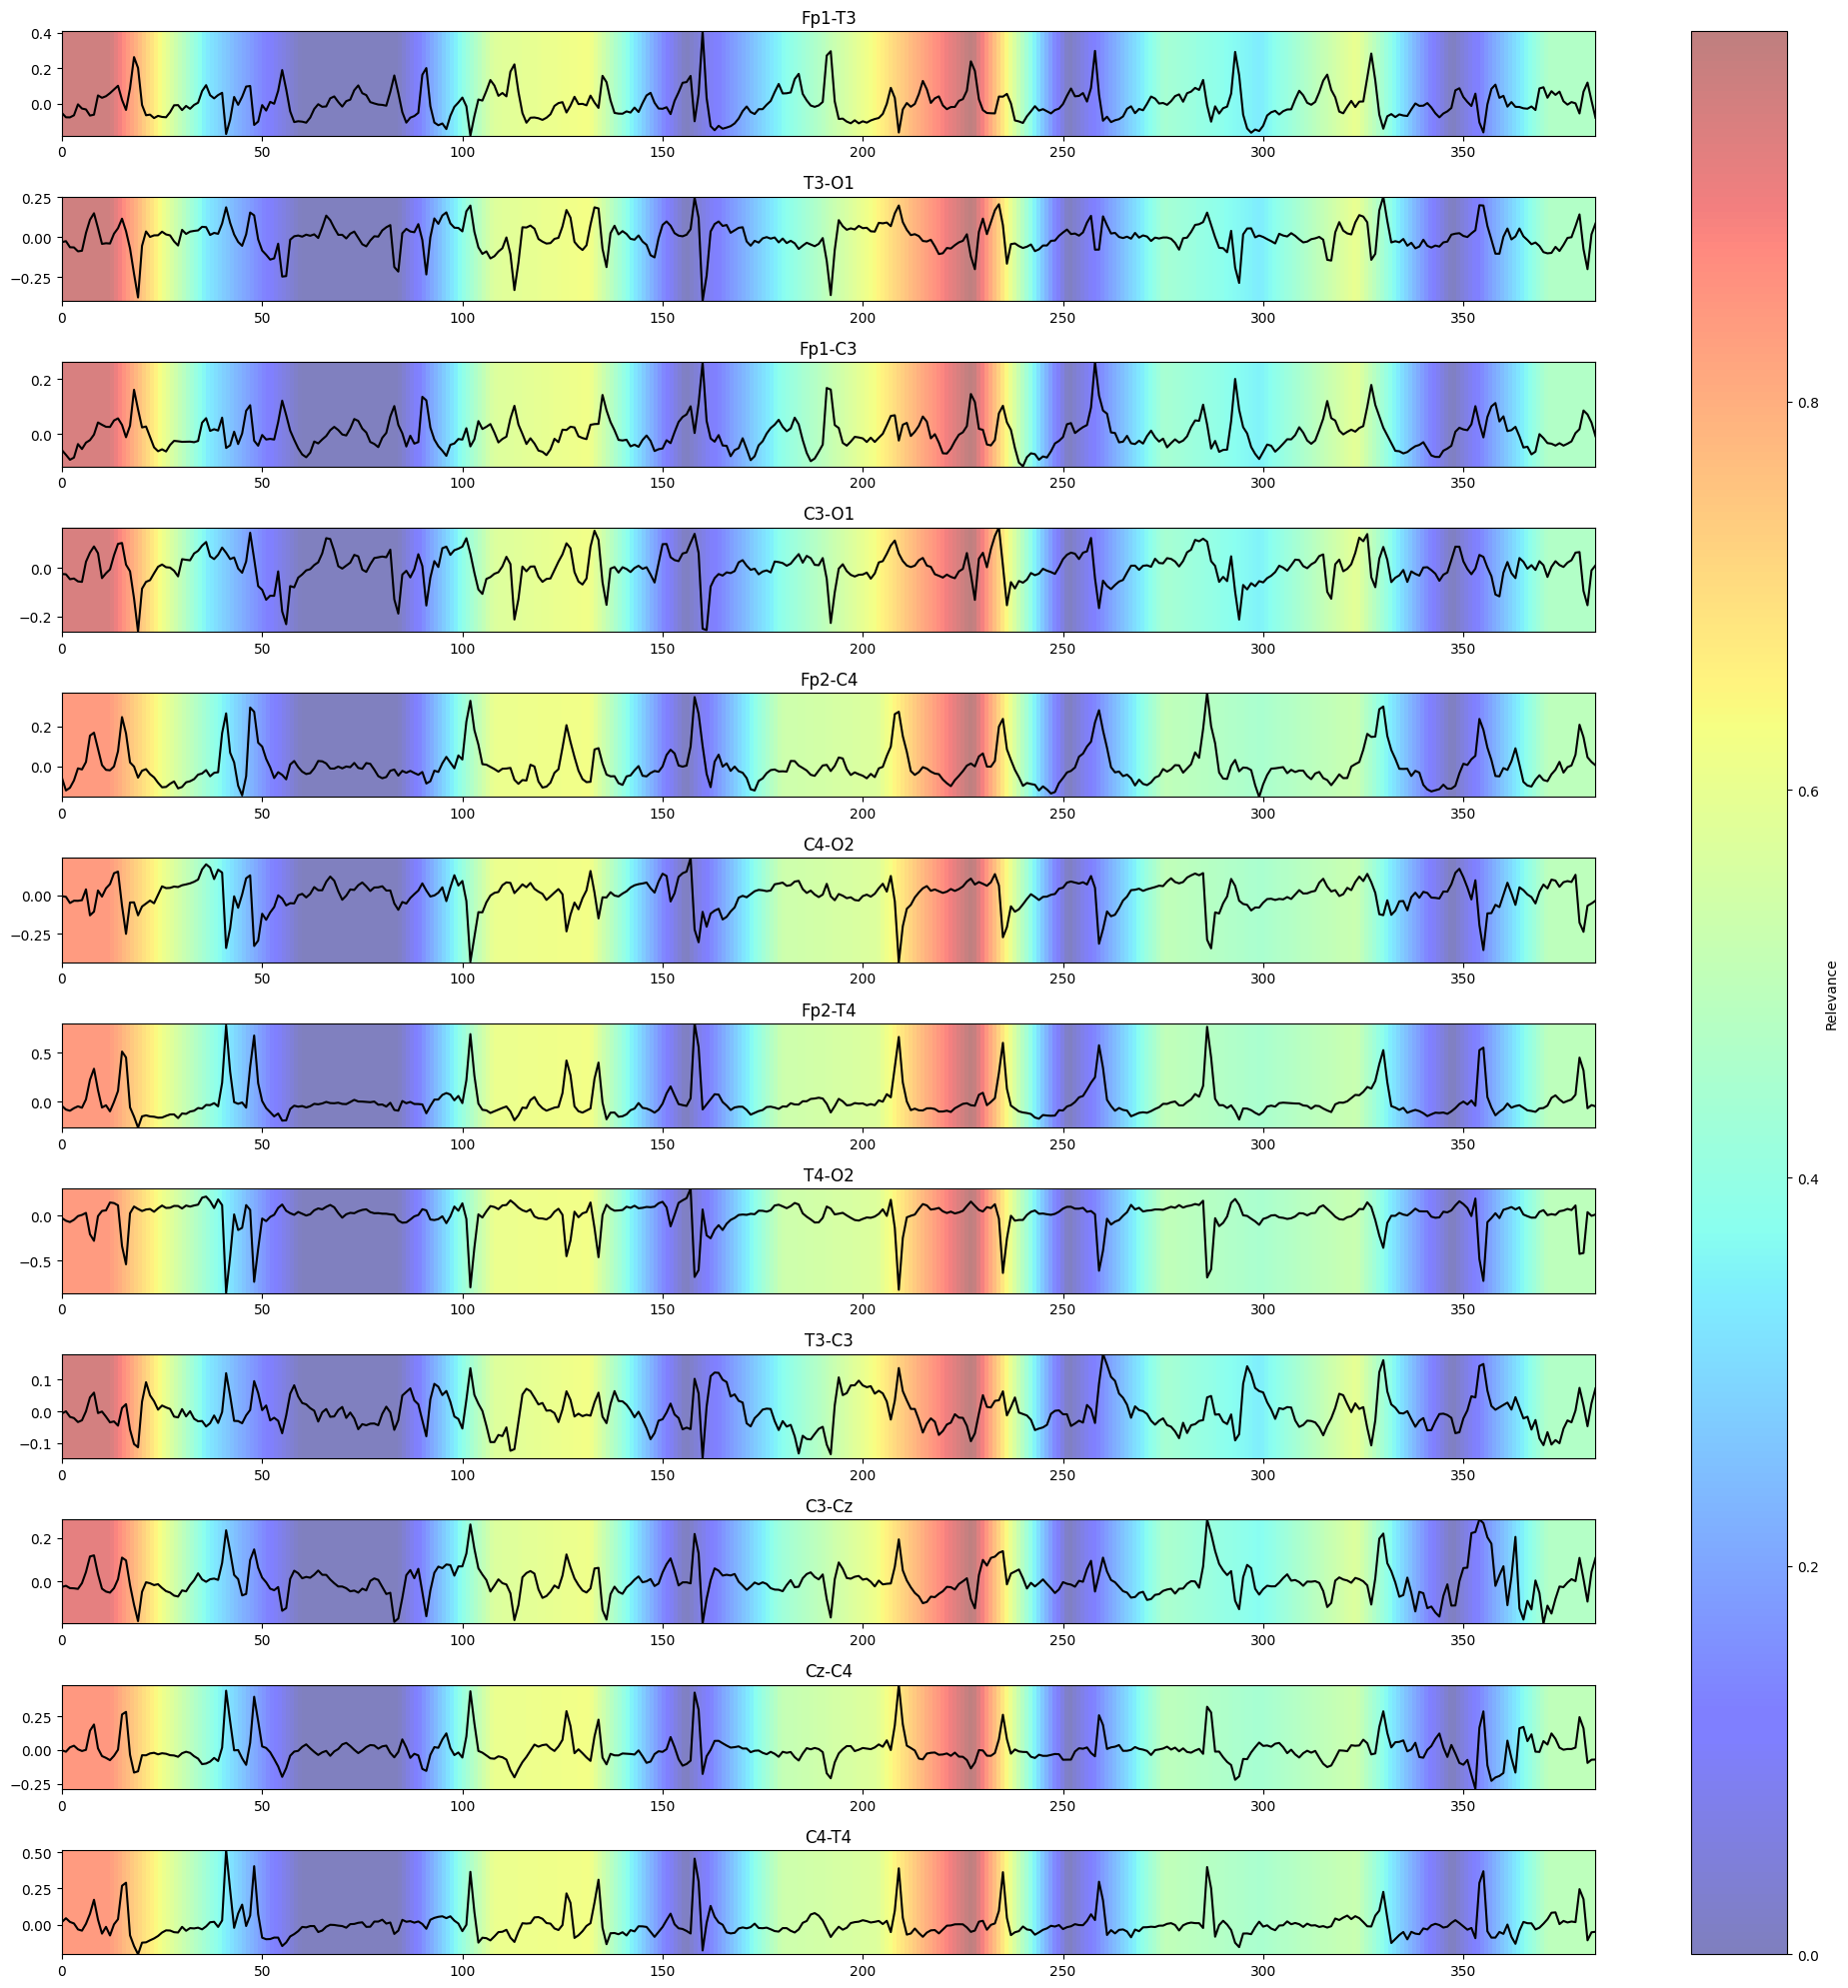

In [77]:
def plot_explainable_signal(signal):

    x1=PreprocesSignal(signal)
    h=GradCAM(x1,model)
    resized_heatmap = cv.resize(h, (384,12), interpolation=cv.INTER_LINEAR)
    # plt.imshow(resized_heatmap,cmap='jet',aspect='auto')
    # plt.colorbar()
    # plt.show()

    channel_names=["Fp1-T3","T3-O1","Fp1-C3","C3-O1","Fp2-C4","C4-O2","Fp2-T4","T4-O2","T3-C3","C3-Cz","Cz-C4","C4-T4"]
    fig,ax=plt.subplots(12,1,figsize=(20,20))

    for r in range(12):
        x=x1[0,r,:,0]
        ax[r].plot(x,color='k')
        im=ax[r].imshow(resized_heatmap[r].reshape(1,384),cmap='jet',alpha=0.5,extent=[0,383,x.min(),x.max()],aspect='auto')
        ax[r].set_title(channel_names[r])
    
    fig.tight_layout()
    cbar=fig.colorbar(im,ax=ax,orientation='vertical',pad=0.05)
    cbar.set_label('Relevance')
    plt.show()

plot_explainable_signal(x_test[3])